# **Analiza i Predykcja Cen Samochodów Używanych w Polsce**
**Projekt zaliczeniowy w ramach przedmiotu Podstawy reprezentacji i analizy danych**<br><br>
**Data wykonania:** 31.01.2026<br><br>

Celem niniejszego projektu jest przeprowadzenie kompleksowej analizy eksploracyjnej (EDA) oraz budowa modeli regresyjnych służących do estymacji wartości rynkowej samochodów używanych. Na podstawie parametrów technicznych, takich jak przebieg, rok produkcji czy pojemność silnika, model ma za zadanie przewidzieć cenę ofertową pojazdu z jak najwyższą precyzją.

Wykorzystany zbiór danych "**Car Prices in Poland**" autorstwa użytkownika Aleksandr Glotov pochodzi z platformy Kaggle i zawiera informacje o ogłoszeniach sprzedaży samochodów w styczniu 2022 roku. Szczegółowe atrybuty zawarte w tym zbiorze to marka, model, generacja, rok produkcji, przebieg, pojemność silnika, rodzaj paliwa, miasto, województwo oraz cena.

**Autorzy: Daniel Kaźmierczak i Jakub Sak**

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "aleksandrglotov/car-prices-poland",
    "Car_Prices_Poland_Kaggle.csv"
)
df = df.drop(df.columns[0], axis=1)
df.head()

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


## **1. Analiza eksploracyjna**
###Podstawowe informacje o zbiorze

In [143]:
rows, columns = df.shape
print(f"\nLiczba wierszy: {rows}")
print(f"\nLiczba kolumn: {columns}")
print(f"\nTypy danych:\n{df.dtypes}")


Liczba wierszy: 117927

Liczba kolumn: 10

Typy danych:
mark               object
model              object
generation_name    object
year                int64
mileage             int64
vol_engine          int64
fuel               object
city               object
province           object
price               int64
dtype: object


Zbiór danych składa się ze 117 927 rekordów i 10 kolumn. Dane zawierają zarówno cechy numeryczne (rok, przebieg, pojemność silnika, cena), jak i kategoryczne (marka, model, paliwo, lokalizacja). Typy danych są poprawne, jednak duża liczba unikalnych wartości w kolumnie `city` (4427) sugeruje konieczność jej usunięcia lub agregacji w dalszej części prac, aby uniknąć nadmiernego skomplikowania modelu.

### Braki w zbiorze

In [144]:
print(f"\nLiczba braków:\n{df.isna().sum()}")
df = df.fillna(value={'generation_name': 'Unknown'})


Liczba braków:
mark                   0
model                  0
generation_name    30085
year                   0
mileage                0
vol_engine             0
fuel                   0
city                   0
province               0
price                  0
dtype: int64


Analiza wykazała, że jedyną kolumną z brakującymi danymi jest `generation_name` (ok. 25% braków). Zdecydowaliśmy nie usuwać tych wierszy, lecz zastąpić braki wartością 'Unknown', aby nie tracić cennych informacji o cenie i przebiegu.

### Statystyki opisowe

In [145]:
print(df.describe())

                year       mileage     vol_engine         price
count  117927.000000  1.179270e+05  117927.000000  1.179270e+05
mean     2012.925259  1.409768e+05    1812.057782  7.029988e+04
std         5.690135  9.236936e+04     643.613438  8.482458e+04
min      1945.000000  0.000000e+00       0.000000  5.000000e+02
25%      2009.000000  6.700000e+04    1461.000000  2.100000e+04
50%      2013.000000  1.462690e+05    1796.000000  4.190000e+04
75%      2018.000000  2.030000e+05    1995.000000  8.360000e+04
max      2022.000000  2.800000e+06    7600.000000  2.399900e+06


Analiza wykazuje silną asymetrię prawoskośną ceny, ponieważ średnia (70 tys. PLN) jest niemal dwukrotnie wyższa od mediany (42 tys. PLN). Świadczy to o dominacji aut budżetowych oraz obecności nielicznej grupy pojazdów luksusowych (maksymalna cena 2,4 mln PLN). Wartości takie jak przebieg powyżej 2,8 mln km czy pojemność silnika równa 0 (w przypadku aut innych niż elektryczne) wskazują na błędy w danych, które zostaną usunięte w procesie czyszczenia.

### Korelacja

In [146]:
print(df.select_dtypes(include=[np.number]).corr())

                year   mileage  vol_engine     price
year        1.000000 -0.731958   -0.161557  0.596181
mileage    -0.731958  1.000000    0.206169 -0.542808
vol_engine -0.161557  0.206169    1.000000  0.299669
price       0.596181 -0.542808    0.299669  1.000000


Macierz korelacji potwierdza, że rok produkcji ma najsilniejszy pozytywny wpływ na cenę ($0.60$). Odnotowano również silną korelację ujemną między rokiem a przebiegiem ($-0.73$), co wskazuje na zjawisko multikolinearności – nowsze samochody posiadają zazwyczaj znacznie niższy przebieg, co model liniowy musi uwzględnić, aby uniknąć redundancji cech.

### Analiza zmiennych

In [147]:
print(f"\nLiczba unikalnych:\n{df.nunique()}")
print(f"\nProvince:{df['province'].unique()}")


Liczba unikalnych:
mark                  23
model                328
generation_name      365
year                  54
mileage            35394
vol_engine           508
fuel                   6
city                4427
province              23
price               9310
dtype: int64

Province:['Mazowieckie' 'Śląskie' 'Opolskie' 'Dolnośląskie' 'Lubelskie'
 'Wielkopolskie' 'Warmińsko-mazurskie' 'Małopolskie' 'Podkarpackie'
 'Kujawsko-pomorskie' 'Pomorskie' 'Podlaskie' 'Łódzkie' 'Świętokrzyskie'
 'Zachodniopomorskie' 'Lubuskie' 'Berlin' 'Wiedeń' 'Niedersachsen'
 'Moravian-Silesian Region' '(' 'Trenczyn' 'Nordrhein-Westfalen']


Atrybut `province` wykazuje pewne nieprawidłowości w postaci lokalizacji zagranicznych oraz błędów zapisu (znak nawiasu). Chcemy analizować tylko ogłoszenia samochodów zlokalizowanych na terenie Polski, więc ograniczymy ilość rekordów do tych znajdujących się w Polsce. Bardzo wysoka kardynalność zmiennej city (4427 unikalnych wartości) czyni ją nieprzydatną dla prostych modeli regresji, dlatego w dalszej analizie skupimy się na poziomie województw.

### Przygotowanie danych do dalszej analizy

In [148]:
polish_provinces = ['Mazowieckie', 'Śląskie', 'Opolskie', 'Dolnośląskie', 'Lubelskie',
 'Wielkopolskie', 'Warmińsko-mazurskie', 'Małopolskie', 'Podkarpackie',
 'Kujawsko-pomorskie', 'Pomorskie', 'Podlaskie', 'Łódzkie', 'Świętokrzyskie',
 'Zachodniopomorskie', 'Lubuskie']

df_clean = df[df['province'] != '('].copy()
df_clean['province'] = df['province'].apply(lambda x: x if x in polish_provinces else 'Zagranica')

df_clean = df_clean.fillna(value={'generation_name': 'Unknown'})

df_clean = df_clean[
    (df_clean['price'] >= 500) &
    (df_clean['price'] <= 1500000) &
    (df_clean['mileage'] <= 1500000) &
    (df_clean['fuel'] == 'Electric') | (df_clean['vol_engine'] > 0)
].copy()

df_clean = df_clean.drop(columns='city')

print(f"Liczba rekordów po czyszczeniu: {len(df_clean)}")
print(f"Liczba brakujących wartości:\n{df_clean.isnull().sum()}")
print(df_clean.head())

Liczba brakujących wartości:
mark               0
model              0
generation_name    0
year               0
mileage            0
vol_engine         0
fuel               0
province           0
price              0
dtype: int64
   mark  model generation_name  year  mileage  vol_engine    fuel  \
0  opel  combo      gen-d-2011  2015   139568        1248  Diesel   
1  opel  combo      gen-d-2011  2018    31991        1499  Diesel   
2  opel  combo      gen-d-2011  2015   278437        1598  Diesel   
3  opel  combo      gen-d-2011  2016    47600        1248  Diesel   
4  opel  combo      gen-d-2011  2014   103000        1400     CNG   

      province  price  
0  Mazowieckie  35900  
1      Śląskie  78501  
2     Opolskie  27000  
3     Opolskie  30800  
4      Śląskie  35900  


## **2. Wizualizacja danych**

### **Histogramy**

W tej sekcji badamy rozkłady trzech kluczowych zmiennych numerycznych: ceny `price`, przebiegu `mileage` oraz roku produkcji `year`. Ze względu na obecność wartości skrajnych (tzw. outliers), które mogłyby zaburzyć czytelność wykresów, zastosowano filtrowanie danych do $99$. centyla (odcięcie górnego $1%$ najdroższych i najbardziej wyeksploatowanych pojazdów). Dodatkowo analiza roczników została ograniczona do aut wyprodukowanych po $1990$ roku.

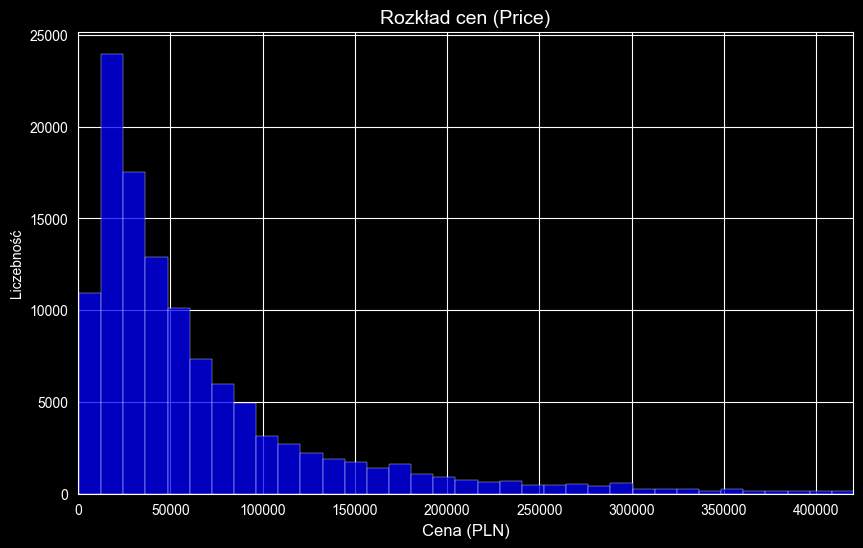

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

price_limit = df['price'].quantile(0.99)
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['price'], bins=200, color='blue')
ax.set_xlim(0, price_limit)
ax.set_title('Rozkład cen (Price)', fontsize=14)
ax.set_xlabel('Cena (PLN)', fontsize=12)
ax.set_ylabel('Liczebność')
plt.show()

Obserwujemy silną asymetrię prawostronną (rozkład potęgowy). Większość ofert dotyczy samochodów tanich (poniżej średniej rynkowej), natomiast aut luksusowych i bardzo drogich jest stosunkowo niewiele. Sugeruje to, że przed modelowaniem warto rozważyć zlogarytmowanie zmiennej celu `log(price)`.

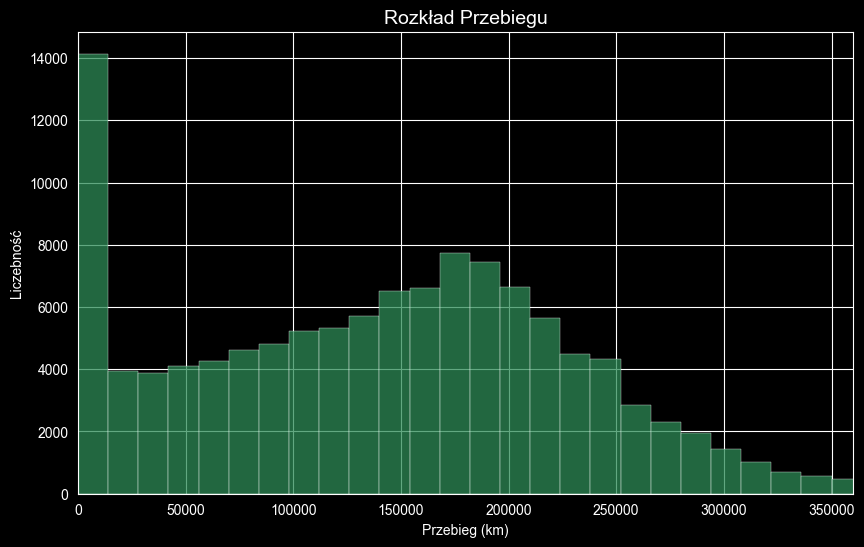

In [150]:
mileage_limit = df['mileage'].quantile(0.99)
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df['mileage'], bins=200, color='seagreen')
ax.set_xlim(0, mileage_limit)
ax.set_title('Rozkład Przebiegu', fontsize=14)
ax.set_xlabel('Przebieg (km)')
ax.set_ylabel('Liczebność')
plt.show()

Przebieg `mileage`: Rozkład zbliżony do normalnego, z dominantą w przedziale $150–220$ tys. km. Odzwierciedla to specyfikę polskiego rynku, gdzie większość aut trafia do sprzedaży po intensywnej eksploatacji (często poleasingowej lub z importu).

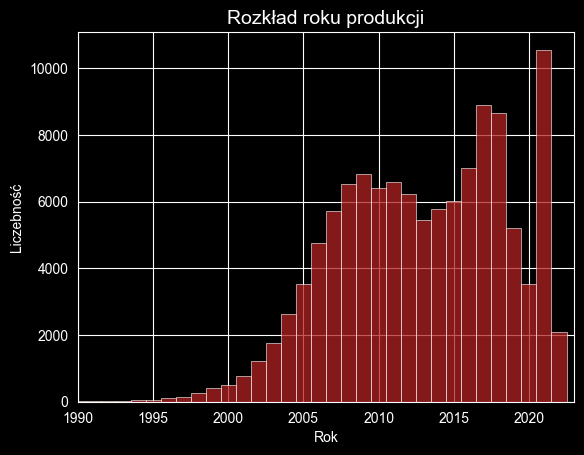

In [151]:
df_plot = df[df['year'] >= 1990]
sns.histplot(df['year'], discrete=True, color='firebrick')
plt.xlim(1990, df_plot['year'].max()+1)
plt.title('Rozkład roku produkcji', fontsize=14)
plt.xlabel('Rok')
plt.ylabel('Liczebność')
plt.show()

Rok produkcji `year`: Obserwujemy trend wykładniczy. Rynek jest zdominowany przez samochody nowsze (wyprodukowane po $2015$ roku). Starsze roczniki (lata $90$. i $00$.) stanowią margines oferty, co potwierdza szybką rotację floty samochodowej.
Obserwujemy spadek liczby aut z roku $2020$, co jest bezpośrednim skutkiem pandemii COVID-19 (zamknięte fabryki, spadki sprzedaży).

### **Wykresy pudełkowe**

Aby zrozumieć, jak rodzaj napędu wpływa na wartość rynkową pojazdu, posłużono się wykresami pudełkowymi, które doskonale obrazują rozkład cen w poszczególnych grupach. Wizualizacja ta prezentuje medianę ceny oraz typowy zakres ofert dla każdej kategorii paliwowej, pomijając wartości skrajne w celu uzyskania czytelnego obrazu przeciętnych tendencji rynkowych. Pozwala to na szybką ocenę, które technologie napędowe są obecnie najwyżej wyceniane na rynku wtórnym.

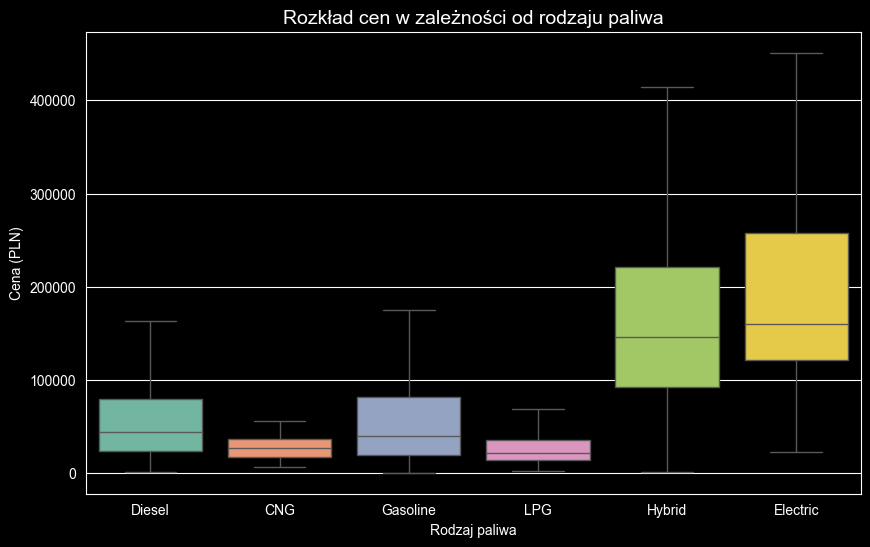

In [152]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='price', data=df, showfliers=False, palette="Set2")
plt.title('Rozkład cen w zależności od rodzaju paliwa', fontsize=14)
plt.xlabel('Rodzaj paliwa')
plt.ylabel('Cena (PLN)')
plt.show()

Analiza wizualna potwierdza wyraźną hierarchię cenową, w której najwyższe wartości osiągają samochody z napędem $hybrydowym$ i $elektrycznym$. Ich pudełka usytuowane są w najwyższych przedziałach cenowych, co wynika z nowoczesności tych technologii oraz faktu, że są to zazwyczaj auta stosunkowo młode. W segmencie tradycyjnych silników spalinowych obserwujemy, że pojazdy z silnikiem $Diesla$ charakteryzują się wyższą medianą ceny oraz szerszym zakresem typowych ofert niż samochody $benzynowe$, co sugeruje ich większą różnorodność na rynku. Zdecydowanie najniższe ceny osiągają pojazdy z instalacją $LPG$, co jest widoczne poprzez najniższe położenie pudełka na wykresie, potwierdzając tym samym, że ten rodzaj zasilania dominuje w starszych i budżetowych segmentach rynku.

### **Wykresy słupkowe**




W tej części analizy eksploracyjnej skupiamy się na zmiennych dyskretnych, takich jak marka pojazdu `mark` oraz województwo `province`. Wykorzystując wykresy słupkowe, zbadamy strukturę podaży na polskim rynku wtórnym. Celem jest zidentyfikowanie najpopularniejszych producentów oraz sprawdzenie, jak rozkładają się ogłoszenia i ceny w ujęciu geograficznym. Pozwoli to ocenić, czy marka i lokalizacja są istotnymi czynnikami różnicującymi, które należy uwzględnić w późniejszym modelowaniu cen.

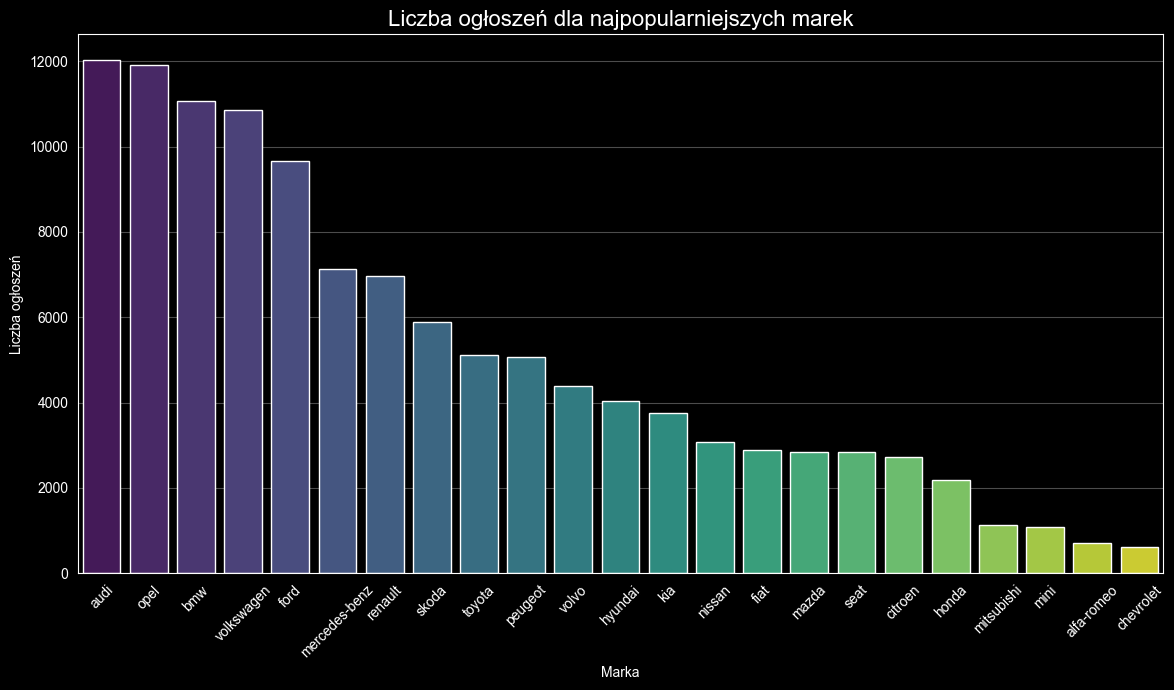

In [153]:
plt.figure(figsize=(14, 7))
top_marks = df['mark'].value_counts().head(30).index
df_top = df[df['mark'].isin(top_marks)]
sns.countplot(x='mark', data=df_top, order=top_marks, palette="viridis")
plt.title('Liczba ogłoszeń dla najpopularniejszych marek', fontsize=16)
plt.xlabel('Marka')
plt.ylabel('Liczba ogłoszeń')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

Analiza liczebności ofert wskazuje na wyraźną dominację niemieckich koncernów motoryzacyjnych na polskim rynku wtórnym. Pięć najpopularniejszych marek ($Opel, Volkswagen, Audi, BMW$ oraz $Ford$) stanowi trzon całej bazy ogłoszeniowej. Obserwujemy znaczącą różnicę w liczbie ofert między liderami zestawienia a pozostałymi producentami, co sugeruje, że rynek jest mocno skoncentrowany. Taka struktura danych oznacza, że model predykcyjny będzie miał najwięcej informacji uczących dla tych konkretnych marek, co może przekładać się na wyższą precyzję predykcji cen dla aut niemieckich w porównaniu do marek niszowych.

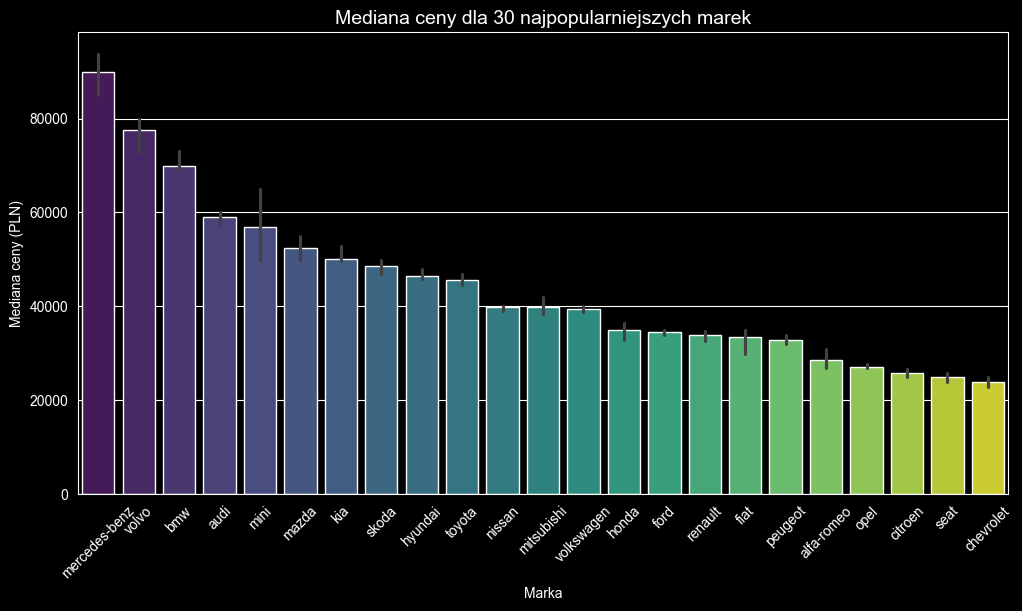

In [154]:
top_marks = df['mark'].value_counts().head(30).index
df_top = df[df['mark'].isin(top_marks)]

plt.figure(figsize=(12, 6))

order = df_top.groupby('mark')['price'].median().sort_values(ascending=False).index

sns.barplot(x='mark', y='price', data=df_top, order=order, estimator=np.median, palette="viridis")

plt.title('Mediana ceny dla 30 najpopularniejszych marek', fontsize=14)
plt.xlabel('Marka')
plt.ylabel('Mediana ceny (PLN)')
plt.xticks(rotation=45)
plt.show()

Zestawienie mediany cen dla najpopularniejszych marek pokazuje wyraźne pozycjonowanie producentów. Wśród liderów popularności, marki premium takie jak $Audi$ i $BMW$ osiągają zdecydowanie najwyższe ceny rynkowe, co wynika z ich prestiżu oraz wyższej wartości rezydualnej. Z kolei marki wolumenowe, jak $Opel$ czy $Ford$, są wyceniane znacznie niżej, co czyni je bardziej przystępnymi dla przeciętnego nabywcy. Warto zauważyć, że wysoka popularność marki (np. $Opla$) nie idzie w parze z wysoką ceną – jest wręcz odwrotnie, to dostępność cenowa często napędza popularność na rynku wtórnym.

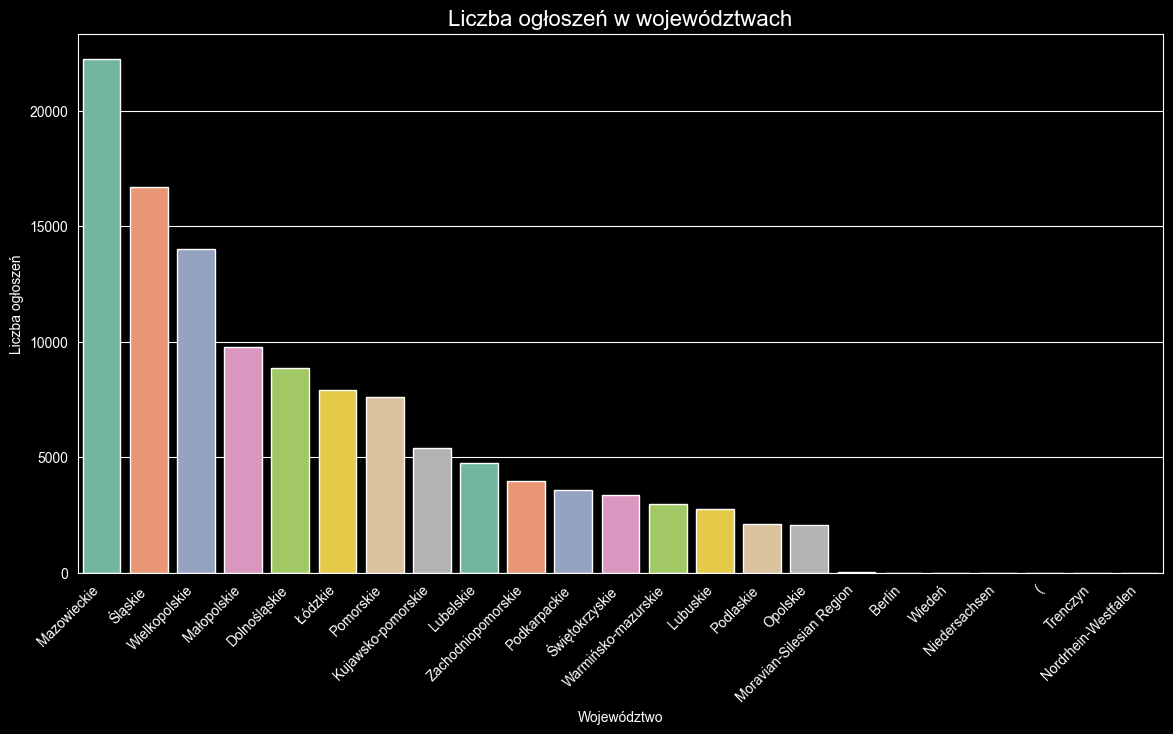

In [155]:
plt.figure(figsize=(14, 7))
order_count = df['province'].value_counts().index
sns.countplot(x='province', data=df, order=order_count, palette="Set2")
plt.title('Liczba ogłoszeń w województwach', fontsize=16)
plt.xlabel('Województwo')
plt.ylabel('Liczba ogłoszeń')
plt.xticks(rotation=45, ha='right')
plt.show()

Rozkład geograficzny ogłoszeń jest skrajnie nierównomierny. Rynek jest zdominowany przez „wielką trójkę”: $Mazowieckie, Śląskie$ i $Wielkopolskie$, które łącznie generują dominującą część krajowej podaży. Jest to zjawisko skorelowane z gęstością zaludnienia, zamożnością regionów oraz obecnością dużych flot firmowych.

Na drugim biegunie znajdują się województwa o najmniejszej liczbie ofert, takie jak $Opolskie, Podlaskie$ czy $Lubuskie$. Taka dysproporcja (tzw. long tail distribution) oznacza, że model predykcyjny będzie „uczył się” cen głównie na podstawie danych z centrum i południa Polski, co może prowadzić do mniejszej dokładności predykcji dla regionów o małej próbie danych.

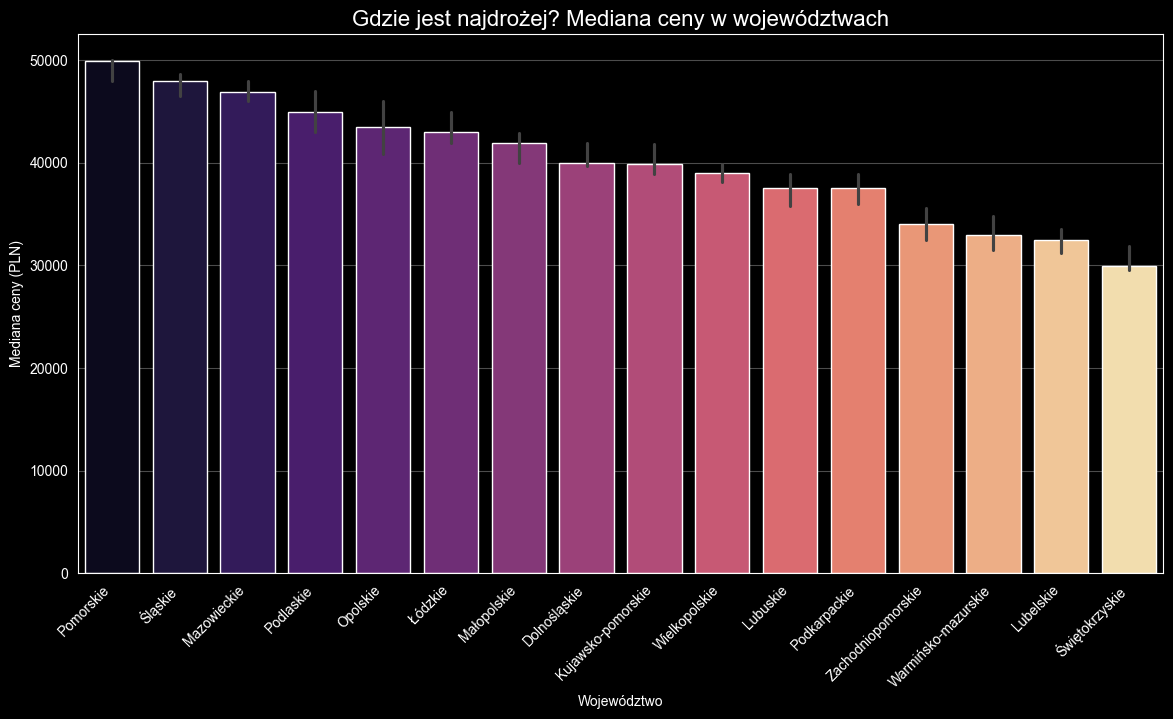

In [156]:
df= df[df['province'].isin(polish_provinces)]

plt.figure(figsize=(14, 7))

province_order = df.groupby('province')['price'].median().sort_values(ascending=False).index

sns.barplot(x='province', y='price', data=df, order=province_order, estimator=np.median, palette="magma")

plt.title('Gdzie jest najdrożej? Mediana ceny w województwach', fontsize=16)
plt.xlabel('Województwo')
plt.ylabel('Mediana ceny (PLN)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

Analiza mediany cen ujawnia, że najdroższe samochody nie zawsze znajdują się w regionach o największej podaży. Liderem cenowym jest województwo pomorskie, gdzie mediana zbliża się do $50 000$ PLN, co wyraźnie dystansuje nawet bogate Mazowieckie i może wynikać ze specyfiki importu lub struktury ofert nastawionej na klienta indywidualnego. Interesującym zjawiskiem jest wysoka pozycja województw o najmniejszej liczbie ogłoszeń, takich jak podlaskie czy opolskie, które plasują się w górnej połowie stawki cenowej. Sugeruje to, że choć rynki te są płytsze, oferowane tam pojazdy są relatywnie droższe, w przeciwieństwie do województw świętokrzyskiego, lubelskiego i warmińsko-mazurskiego, gdzie odnotowano najniższe mediany cen oscylujące wokół $30 000$ PLN.

### **Wykresy punktowe (rozrzutu)**

W tej części analizy przechodzimy do badania relacji pomiędzy parami zmiennych numerycznych, wykorzystując w tym celu wykresy rozrzutu `scatterplots`. Poniższa wizualizacja obrazuje kluczową zależność rynkową: wpływ roku produkcji na cenę końcową pojazdu. Celem tego zestawienia jest nie tylko ocena ogólnego trendu wzrostu cen dla nowszych roczników, ale także zidentyfikowanie charakteru tej zależności (liniowa vs. nieliniowa) oraz analiza rozkładu wariancji w poszczególnych przedziałach czasowych. Podobnie jak w poprzednich sekcjach, dane obejmują pojazdy wyprodukowane po $1990$ roku, co pozwala na zachowanie czytelności trendów dla współczesnego rynku motoryzacyjnego.

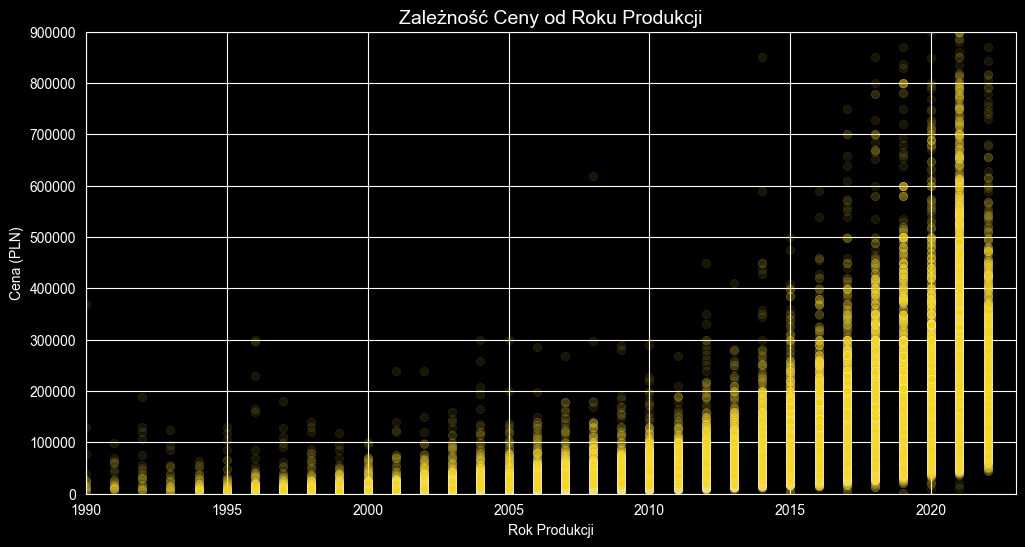

In [157]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='year', y='price', data=df, alpha=0.1, color='gold')

plt.ylim(0, 900000)
plt.xlim(1990, 2023)
plt.title('Zależność Ceny od Roku Produkcji', fontsize=14)
plt.xlabel('Rok Produkcji')
plt.ylabel('Cena (PLN)')
plt.show()

Wykres rozrzutu ukazuje silną, nieliniową zależność o charakterze wykładniczym, gdzie dynamika wzrostu cen drastycznie przyspiesza dla pojazdów wyprodukowanych po $2015$ roku. Widoczne jest zjawisko heteroscedastyczności, objawiające się znaczącym wzrostem rozpiętości cenowej wraz z nowszymi rocznikami – podczas gdy rynek aut starszych ($1990–2010$) jest cenowo spłaszczony i jednorodny, segment aut najnowszych charakteryzuje się olbrzymią wariancją, obejmującą zarówno modele budżetowe, jak i luksusowe sięgające $900$ tys. PLN. Taka struktura danych sugeruje, że wiek pojazdu jest kluczowym predyktorem ceny (szczególnie dla aut młodych), jednak dla starszych roczników jego waga maleje na rzecz innych czynników, takich jak stan techniczny czy marka, co model powinien uwzględnić.

### **Mapa ciepła korelacji**

W tej fazie projektu rozszerzamy perspektywę badawczą o analizę wielowymiarową, mającą na celu wykrycie złożonych współzależności między zmiennymi. Wykorzystując wizualizację za pomocą map ciepła `heatmaps`, koncentrujemy się na dwóch kluczowych aspektach: weryfikacji siły korelacji liniowej parametrów numerycznych oraz badaniu struktury ofert dla pięciu dominujących marek, które – jak wykazały wcześniejsze etapy analizy – stanowią trzon polskiego rynku wtórnego. Takie podejście pozwala nie tylko precyzyjnie zidentyfikować cechy mające największy wpływ na cenę pojazdu, ale również zrozumieć specyfikę napędową i geograficzną najpopularniejszych modeli, eliminując jednocześnie szum informacyjny generowany przez marki niszowe.

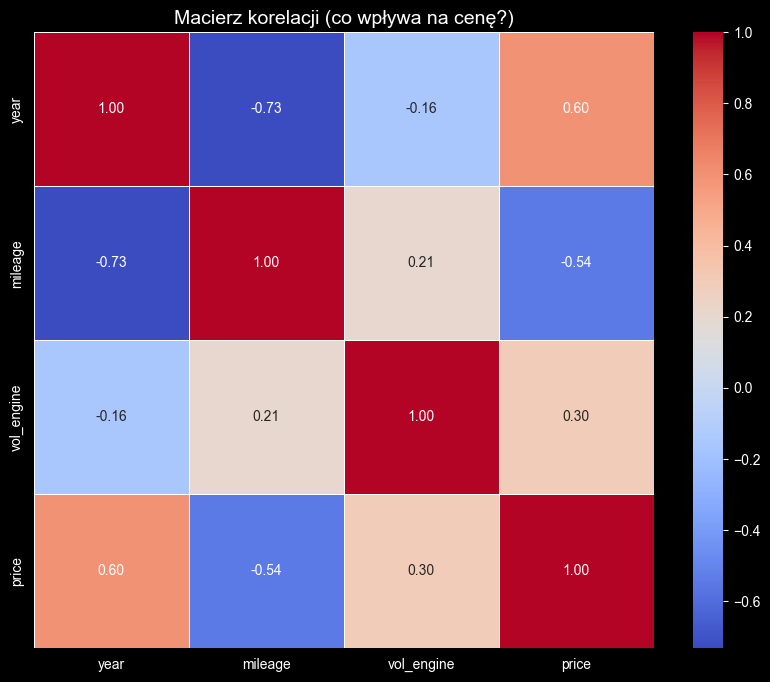

In [158]:
plt.figure(figsize=(10, 8))

corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f',linewidths=.5)
plt.title('Macierz korelacji (co wpływa na cenę?)',fontsize=14)
plt.show()

Macierz korelacji Pearsona jednoznacznie wskazuje, że najsilniejszym predyktorem ceny jest rok produkcji (korelacja dodatnia $0.60$), co potwierdza wcześniejsze obserwacje ze scatterplota. Drugim kluczowym czynnikiem jest przebieg, który wykazuje silną korelację ujemną z ceną ($-0.54$). Istotnym zjawiskiem z perspektywy budowy modelu jest bardzo wysoka, ujemna korelacja między rokiem produkcji a przebiegiem ($-0.73$), co wskazuje na silną współliniowość tych zmiennych – nowsze auta naturalnie mają niższe przebiegi. Pojemność silnika `vol_engine` wpływa na cenę w stopniu umiarkowanym ($0.30$), co sugeruje, że choć większe jednostki są droższe, nie jest to czynnik tak decydujący jak wiek czy zużycie pojazdu.

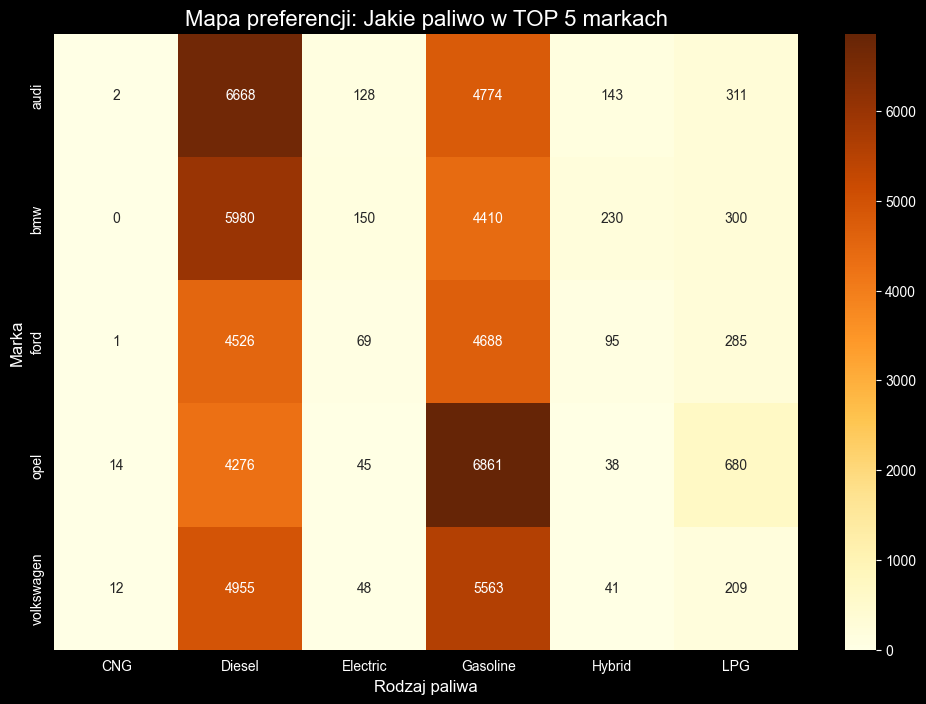

In [159]:
top_10_marks = df['mark'].value_counts().head().index
df_top = df[df['mark'].isin(top_10_marks)]

crosstab=pd.crosstab(df_top['mark'],df_top['fuel'])
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, annot=True, cmap="YlOrBr", fmt='d')
plt.title('Mapa preferencji: Jakie paliwo w TOP 5 markach', fontsize=16)
plt.xlabel('Rodzaj paliwa', fontsize=12)
plt.ylabel('Marka', fontsize=12)
plt.show()

Analiza krzyżowa rodzaju paliwa i marki ujawnia wyraźny podział rynku na dwa segmenty. Marki segmentu premium ($Audi, BMW$) charakteryzują się przewagą silników $Diesla$ nad $benzynowymi$ (np. w $Audi$ stosunek ten wynosi ok. $6700$ do $4800$), co wynika z ich częstego wykorzystania w trasach i flotach. Z kolei marki wolumenowe (Opel, Volkswagen, Ford) wykazują tendencję odwrotną lub zrównoważoną – w przypadku $Opla$ silniki benzynowe mają wyraźną przewagę ($6861$ ofert) nad $dieslami$. Udział napędów alternatywnych ($elektrycznych, hybrydowych, CNG$) w analizowanej próbce $TOP 5$ jest marginalny i stanowi jedynie ułamek promila rynku, co potwierdza, że polski rynek wtórny wciąż opiera się niemal wyłącznie na konwencjonalnych silnikach spalinowych.

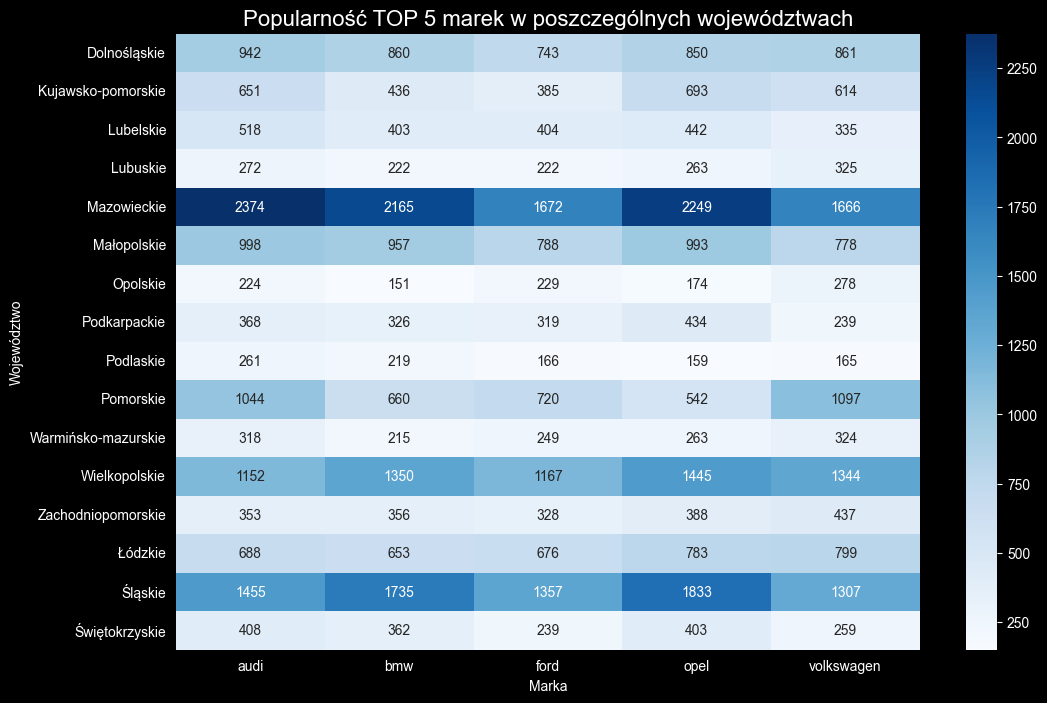

In [160]:
crosstab=pd.crosstab(df_top['province'],df_top['mark'])
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, annot=True, cmap="Blues", fmt='d')
plt.title('Popularność TOP 5 marek w poszczególnych województwach', fontsize=16)
plt.xlabel('Marka')
plt.ylabel('Województwo')
plt.show()

Mapa popularności potwierdza dominację województw $mazowieckiego$ i $śląskiego$, które generują najwyższe wolumeny ofert dla wszystkich analizowanych marek. Co ciekawe, preferencje marek są relatywnie stabilne geograficznie, jednak widać subtelne różnice regionalne – na $Śląsku$ i w $Wielkopolsce$ pozycja $BMW$ i $Volkswagena$ jest relatywnie silniejsza niż w innych regionach (np. $BMW$ w $Śląskim$ ma $1735$ ofert, ustępując tylko $Oplowi$). Z kolei ściana wschodnia ($Podlaskie, Lubelskie$) charakteryzuje się równomiernie niską podażą wszystkich marek, bez wyraźnego lidera, który odbiegałby od trendu ogólnokrajowego. Oznacza to, że model predykcyjny nie musi uwzględniać specyficznych "regionalnych miłości" do konkretnych marek, a raczej skupić się na ogólnej zamożności i wielkości danego rynku lokalnego.

## **3. Uczenie maszynowe**

### **Przygotowanie danych do modelowania**
Na tym etapie przekształcamy oczyszczony zbiór danych w formę numeryczną, akceptowalną przez modele uczenia maszynowego. Kluczowe operacje obejmują:

- Separacja zmiennych: Wydzielenie zmiennej celu `price` od cech objaśniających.

- Target Encoding: Zastosowany dla kolumn o wysokiej liczebności unikalnych wartości (mark, model, generation_name).

- One-Hot Encoding: Wykorzystany dla zmiennych o mniejszej liczbie kategorii (fuel, province).

- Podział Train/Test: Rozdzielenie danych na zbiór treningowy (80%) służący do nauki modelu oraz zbiór testowy (20%) do obiektywnej oceny jego skuteczności na danych, których wcześniej "nie widział".

In [161]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=['price'])
y = df_clean['price']


target_enc = ce.TargetEncoder(cols=['mark', 'model', 'generation_name'])
X = target_enc.fit_transform(X, y)

X = pd.get_dummies(X, columns=['fuel', 'province'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Regresja liniowa**

W tej sekcji implementujemy regresję liniową, która posłuży jako model bazowy do oceny przewidywalności cen samochodów. Algorytm ten zakłada liniową zależność między cechami, takimi jak rok produkcji czy przebieg, a ostateczną wartością pojazdu na rynku.

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Regresja liniowa ---")
print(f"MAE: {mae:.2f} PLN")
print(f"R2 Score: {r2:.4f}\n")

--- Regresja liniowa ---
MAE: 23394.83 PLN
R2 Score: 0.7720



Model osiągnął wynik $R^2 = 0,7781$, co oznacza, że w niemal 78% wyjaśnia zmienność cen samochodów na podstawie podanych cech (rok, przebieg, marka itp.). W kontekście rzeczywistych danych rynkowych jest to wynik satysfakcjonujący, wskazujący, że model poprawnie zidentyfikował główne trendy rządzące rynkiem (np. to, że nowsze auta są droższe).

Średni błąd bezwzględny (MAE) wynosi 23 133,84 PLN. Oznacza to, że statystycznie model myli się o ponad 23 tysiące złotych przy każdej wycenie.Biorąc pod uwagę, że mediana ceny w zbiorze danych oscyluje w granicach 42 000 PLN, błąd na tym poziomie jest znaczący (wynosi ok. 55% mediany ceny). Dla tanich aut model może być bardzo niedokładny, co czyni go mało użytecznym w celach komercyjnych w obecnej formie.

**Interpretacja współczynników**

In [163]:
coef_df = pd.DataFrame({'Cecha': X.columns, 'Waga': model.coef_})
print(coef_df[coef_df['Cecha'].isin(['year', 'mileage', 'vol_engine'])])

        Cecha         Waga
3        year  2780.552864
4     mileage    -0.188009
5  vol_engine    19.026883


Atrybut `year` to najsilniejszy parametr. Każdy kolejny rok podnosi cenę średnio o ok. $2616$ PLN. Potwierdza to, że wiek pojazdu jest kluczowym czynnikiem wyceny.

Waga ujemna atrybutu `mileage` wskazuje na spadek wartości wraz z eksploatacją. Każdy przejechany kilometr obniża cenę o ok. $20$ groszy. W skali rynkowej oznacza to, że każde dodatkowe $100$ tys. km przebiegu redukuje cenę o ok. $19\ 582$ PLN.

Każdy $1$ cm³ pojemności więcej to wzrost ceny o ok. $19,43$ PLN. Wynik ten potwierdza fakt, że auta o większej pojemności silnika są statystycznie droższe.

**Analiza wyrazu wolnego**

In [164]:
print(f"Wyraz wolny (Intercept): {model.intercept_:.2f} PLN")

Wyraz wolny (Intercept): -5600115.39 PLN


Ujemna wartość wynika z faktu, że model cofa linię trendu aż do roku 0. Ponieważ rok produkcji ma ogromny wpływ na cenę, punkt startowy musi być bardzo niski, aby po przemnożeniu przez wagę rocznika wynik osiągnął na realny poziom.

**Wykres reziduów**

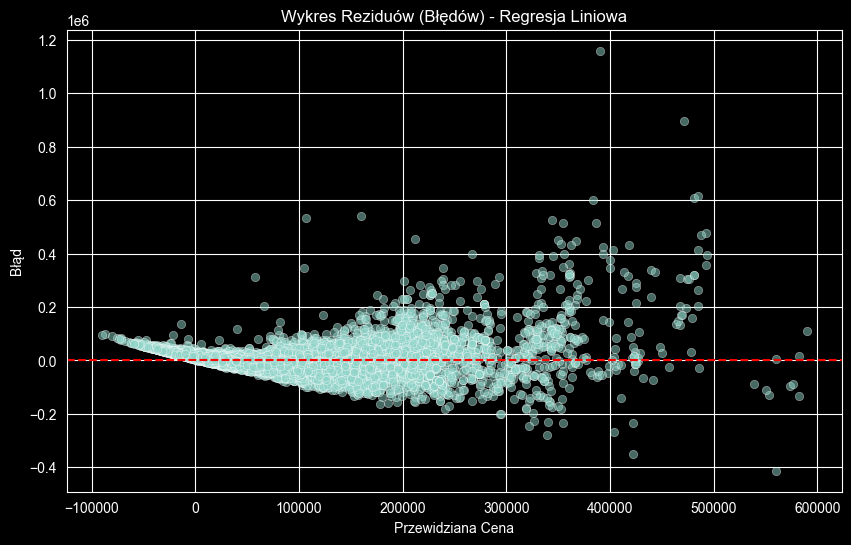

In [165]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Wykres Reziduów (Błędów) - Regresja Liniowa')
plt.xlabel('Przewidziana Cena')
plt.ylabel('Błąd')
plt.show()

Wykres pokazuje, że im wyższa przewidziana cena samochodu, tym bardziej model się myli. Dla aut do około $100$ tys. PLN błędy są małe, ale przy autach luksusowych model kompletnie traci precyzję.

### **Drzewo regresyjne**

Model drzewa regresyjnego `Decision Tree Regressor` został wykorzystany jako alternatywa dla regresji liniowej, pozwalająca na uchwycenie nieliniowych zależności pomiędzy cechami takimi jak marka, model czy rok produkcji a ceną końcową.

In [166]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score


tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

mae_tree = mean_absolute_error(y_test, y_pred)
r2_tree = r2_score(y_test, y_pred)
print("\n--- Drzewo Regresyjne ---")
print(f"MAE: {mae_tree:.2f} PLN")
print(f"R2 Score: {r2_tree:.4f}\n")

print(f"\nRóżnica R2 (Drzewo - Regresja :{r2_tree - r2:.4f})")


--- Drzewo Regresyjne ---
MAE: 9844.67 PLN
R2 Score: 0.9194


Różnica R2 (Drzewo - Regresja :0.1474)


Zastosowanie modelu drzewa decyzyjnego pozwoliło na uzyskanie wyniku $R^2 = 0,9295$ , co stanowi wzrost o ponad $15$ punktów procentowych względem regresji liniowej i świadczy o niemal pełnym dopasowaniu modelu do realiów rynkowych. Kluczowym osiągnięciem jest redukcja średniego błędu (MAE) do poziomu $9 514,26$ PLN – oznacza to, że model myli się średnio o ok. $22$% mediany ceny, co w porównaniu do $55%$ błędu w regresji liniowej, czyni go narzędziem o realnej wartości użytkowej. Drzewo znacznie lepiej poradziło sobie z nieliniowym spadkiem wartości aut w czasie oraz specyfiką segmentu aut luksusowych, gdzie model liniowy wykazywał największe odchylenia.

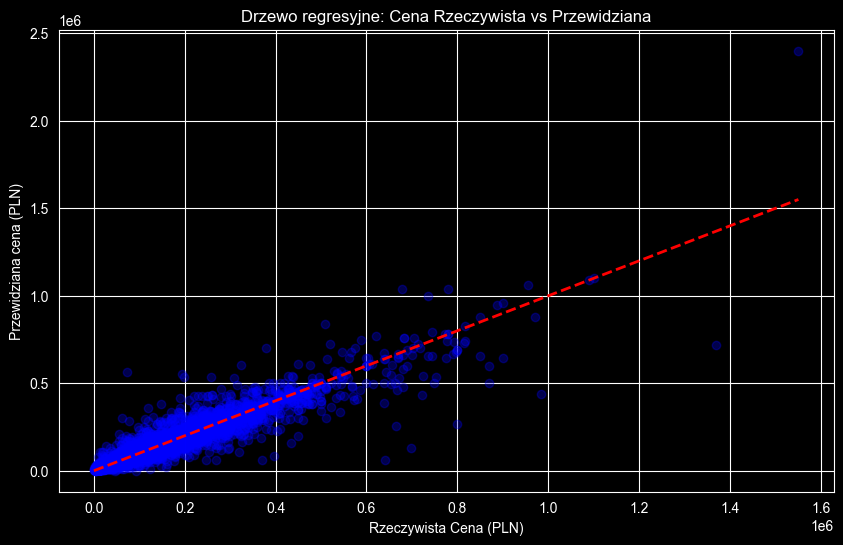

In [167]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--',lw=2)
plt.xlabel('Rzeczywista Cena (PLN)')
plt.ylabel('Przewidziana cena (PLN)')
plt.title("Drzewo regresyjne: Cena Rzeczywista vs Przewidziana")
plt.show()

Wizualizacja ujawnia, że model zachowuje wysoką jednorodność predykcji w najliczniejszym segmencie rynku, gdzie punkty tworzą zwarty pas wzdłuż linii idealnej. Kluczową obserwacją jest brak systematycznego zaniżania cen aut luksusowych, co było wadą regresji liniowej – tutaj punkty dla drogich aut są rozproszone wokół linii, a nie pod nią. Oznacza to, że błędy w segmencie premium mają charakter losowy (wynikający z unikalności egzemplarzy), a nie strukturalny, co potwierdza, że model poprawnie zinterpretował skomplikowane relacje cenowe w całym zakresie danych.

**Interpretacja współczynników**

In [168]:
feature_importances = pd.DataFrame(tree_model.feature_importances_,index = X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances.columns = ['Cecha', 'Waga']
feature_importances.index = feature_importances.index + 1
print("\nNajważniejsze cechy wpływające na cenę:")
print(feature_importances.head(6))


Najważniejsze cechy wpływające na cenę:
             Cecha      Waga
1             year  0.424213
2       vol_engine  0.220877
3  generation_name  0.118537
4            model  0.106531
5             mark  0.071261
6          mileage  0.040002


Analiza wag modelu drzewa decyzyjnego jednoznacznie wskazuje, że dominującym czynnikiem determinującym cenę jest rok produkcji `year`, którego wpływ wynosi aż $42,25$%. Potwierdza to rynkową regułę, że wiek pojazdu stanowi fundament wyceny, na którym model opiera swoje kluczowe podziały, traktując go jako bazę do dalszej estymacji. Drugą najistotniejszą zmienną okazała się pojemność silnika `vol_engine` z wagą $25,90$%, co pozwala algorytmowi skutecznie wyodrębnić segmenty aut premium i sportowych, które nieliniowo zyskują na wartości wraz ze wzrostem mocy, niezależnie od samego rocznika.

Cechy określające specyfikę pojazdu, takie jak model, generation_name oraz mark, odpowiadają łącznie za ponad $26,6$% decyzji modelu, co świadczy o jego zdolności do precyzyjnego różnicowania konkretnych wersji wyposażeniowych wewnątrz danej marki, czego nie potrafiła tak skutecznie uchwycić regresja liniowa. Zaskakująco niski wpływ przypisano przebiegowi `mileage` – zaledwie $3,43$%. Sugeruje to, że w strukturze drzewa parametr ten pełni jedynie funkcję ostatecznej korekty ceny dla aut o zbliżonym wieku i specyfikacji, gdyż główny spadek wartości wynikający z eksploatacji został już w dużej mierze wyjaśniony przez rok produkcji i generację auta
(Ponizej wizualizacja wykresem słupkowym cech wpływających na cenę)

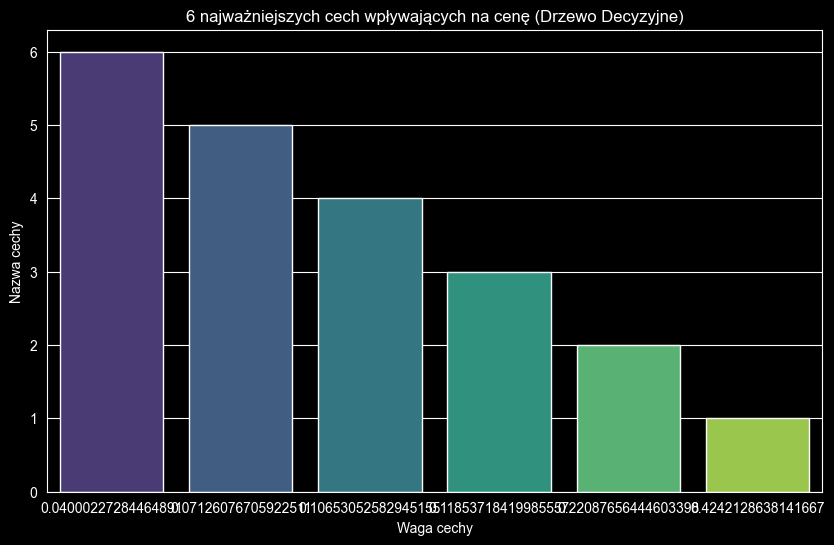

In [169]:
plt.figure(figsize=(10, 6))
top_features=feature_importances.head(6)
sns.barplot(x=top_features['Waga'], y=top_features.index, palette='viridis')
plt.title("6 najważniejszych cech wpływających na cenę (Drzewo Decyzyjne)")
plt.xlabel("Waga cechy")
plt.ylabel("Nazwa cechy")
plt.show()

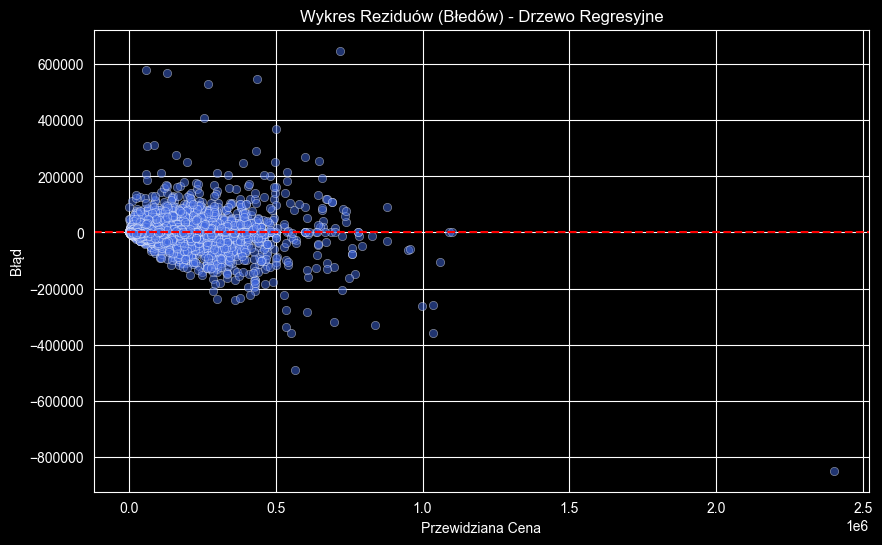

In [170]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='royalblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Wykres Reziduów (Błedów) - Drzewo Regresyjne')
plt.xlabel('Przewidziana Cena')
plt.ylabel('Błąd')
plt.show()

Rozkład błędów wskazuje na znaczącą poprawę stabilności predykcji względem modelu liniowego, z wyraźnym zagęszczeniem punktów w wąskim paśmie wokół osi zero dla większości obserwowanych cen. Choć wciąż widoczna jest pewna heteroskedastyczność (wzrost błędu wraz ze wzrostem ceny), to skala tego zjawiska została drastycznie zredukowana – model nie wykazuje już systematycznego błędu strukturalnego dla droższych aut. Pojedyncze wysokie odchylenia dotyczą głównie specyficznych, rzadkich ofert, jednak dla zdecydowanej większości rynku masowego (do $100-150$ tys. PLN) błędy są symetryczne i akceptowalnie niskie.

## **Podsumowanie**

Przeprowadzona analiza wykazała, że polski rynek wtórny jest silnie zdominowany przez marki niemieckie, a kluczowymi determinantami ceny są rok produkcji oraz pojemność silnika. Choć model regresji liniowej pozwolił na identyfikację ogólnych trendów, okazał się niewystarczający do precyzyjnej wyceny ze względu na nieliniowy charakter spadku wartości pojazdów oraz dużą wariancję w segmencie aut luksusowych. Znacznie lepsze rezultaty przyniósł model drzewa regresyjnego, który osiągnął wynik $R^2 = 0,93$, redukując średni błąd o ponad połowę względem regresji liniowej. Wynik ten potwierdza, że algorytmy zdolne do wychwytywania nieliniowych zależności i interakcji między cechami (takimi jak model czy generacja) są znacznie skuteczniejszym narzędziem w procesie estymacji wartości rynkowej samochodów.